# Train Low Test Models

This notebook is a streamlined notebook for generating minima of low test accuracy through three different means:
- Dataset Poisoning
- Adding Noise to Data
- Decreasing Dataset Sizes

## Imports

In [1]:
# Standard library
import copy
import os
import sys
import time

# Third-party
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Local package imports
from minima_volume.dataset_funcs import (
    prepare_datasets,
    save_dataset,
    save_model,
)
from minima_volume.train_funcs import evaluate, train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Input Parameters

In [2]:

# ==============================
# Base Input Parameters
# ==============================
# --- SEEDS ---
data_seed = 19            
model_seed = 9           

# --- Training configuration ---
epochs = 3000            

# --- Dataset configuration ---
base_data_size = 60      
dataset_type = "data"   
dataset_quantities = [0, 600-60, 2000 - 60, 6000 - 60, 20000 - 60, 60000 - 60]

# --- Output configuration ---
base_output_dir = ""     
save_generated_dataset = True   
save_generated_models = True    


## Model + Dataset Specific Code

This is for specific code.

In [3]:
# User specifies the model module name
from minima_volume.models import MNIST_model_data as model_module

# Generate dataset
x_base, y_base, x_test, y_test = model_module.get_dataset(
    device = device
)

# MNIST specific initialization parameters
hidden_dims = [256, 128]

# Grab model
model_template = model_module.get_model(hidden_dims=hidden_dims, device=device, seed=model_seed)

# Grab loss and metrics
loss_fn = model_module.get_loss_fn()
other_metrics = model_module.get_additional_metrics()

## Training

We generate the various datasets used to train our models here, before training them. We record the losses, and what each model was trained on.

In [4]:
# ==============================
# Prepare datasets
# ==============================
x_base_train, y_base_train, x_additional, y_additional = prepare_datasets(
    x_base=x_base,
    y_base=y_base,
    dataset_type=dataset_type,
    dataset_quantities=dataset_quantities,
    base_data_size=base_data_size,
    data_seed=data_seed,
    seed_1=None,
    seed_2=None,
)

x_base_train = x_base_train.to(device)
y_base_train = y_base_train.to(device)
x_additional = x_additional.to(device)
y_additional = y_additional.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

# ==============================
# Training loop
# ==============================
all_models = []

for additional_data in dataset_quantities:
    # Assemble training dataset
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    # Initialize model (defined in the model-specific file)
    torch.manual_seed(model_seed)
    model = copy.deepcopy(model_template)
    optimizer = optim.SGD(
        model.parameters(),
        lr=1e-2,         # usually requires higher LR than AdamW
        momentum=0.9,    # typical value, helps convergence
        weight_decay=1e-4  # optional, acts like L2 regularization
    )
    batch_size = len(x_train)

    # Train model
    train_loss, train_other_metrics, test_loss, test_other_metrics = train(
        model = model,
        x_train = x_train, y_train = y_train,
        x_test = x_test, y_test = y_test,
        loss_fn = loss_fn,
        metrics = other_metrics,
        optimizer = optimizer,
        epochs=epochs,
        batch_size=batch_size,
        verbose_every=100,
    )
    
    # Build dictionary dynamically for additional metrics
    train_metrics_dict = {}
    test_metrics_dict = {}
    if train_other_metrics is not None:
        # train_other_metrics is a list of dicts per epoch
        for metric_name in train_other_metrics[0].keys():  # keys from first epoch
            train_metrics_dict[f"train_{metric_name}"] = [m[metric_name] for m in train_other_metrics]
            test_metrics_dict[f"test_{metric_name}"] = [m[metric_name] for m in test_other_metrics]
    
    # Store results
    trained_model = {
        "model": model,
        "train_loss": train_loss,
        "test_loss": test_loss,
        "additional_data": additional_data,
        "dataset_type": dataset_type,
        **train_metrics_dict,  # dynamically include additional metrics
        **test_metrics_dict,
    }
    
    all_models.append(trained_model)

    print(f"Completed training with {additional_data} additional samples of {dataset_type}")

    # Free memory (important for large GPU datasets)
    del x_train, y_train
    torch.cuda.empty_cache()


Epoch 1/3000: Train Loss 2.2968 | Test Loss 2.3053 | accs Train 0.1833 Test 0.1424


Epoch 100/3000: Train Loss 0.0087 | Test Loss 0.9313 | accs Train 1.0000 Test 0.7204


Epoch 200/3000: Train Loss 0.0034 | Test Loss 0.9727 | accs Train 1.0000 Test 0.7219


Epoch 300/3000: Train Loss 0.0021 | Test Loss 0.9986 | accs Train 1.0000 Test 0.7223


Epoch 400/3000: Train Loss 0.0015 | Test Loss 1.0182 | accs Train 1.0000 Test 0.7216


Epoch 500/3000: Train Loss 0.0011 | Test Loss 1.0337 | accs Train 1.0000 Test 0.7212


Epoch 600/3000: Train Loss 0.0009 | Test Loss 1.0465 | accs Train 1.0000 Test 0.7205


Epoch 700/3000: Train Loss 0.0008 | Test Loss 1.0573 | accs Train 1.0000 Test 0.7203


Epoch 800/3000: Train Loss 0.0007 | Test Loss 1.0668 | accs Train 1.0000 Test 0.7203


Epoch 900/3000: Train Loss 0.0006 | Test Loss 1.0750 | accs Train 1.0000 Test 0.7201


Epoch 1000/3000: Train Loss 0.0005 | Test Loss 1.0824 | accs Train 1.0000 Test 0.7200


Epoch 1100/3000: Train Loss 0.0005 | Test Loss 1.0889 | accs Train 1.0000 Test 0.7194


Epoch 1200/3000: Train Loss 0.0004 | Test Loss 1.0949 | accs Train 1.0000 Test 0.7191


Epoch 1300/3000: Train Loss 0.0004 | Test Loss 1.1003 | accs Train 1.0000 Test 0.7190


Epoch 1400/3000: Train Loss 0.0004 | Test Loss 1.1054 | accs Train 1.0000 Test 0.7188


Epoch 1500/3000: Train Loss 0.0004 | Test Loss 1.1100 | accs Train 1.0000 Test 0.7187


Epoch 1600/3000: Train Loss 0.0003 | Test Loss 1.1142 | accs Train 1.0000 Test 0.7189


Epoch 1700/3000: Train Loss 0.0003 | Test Loss 1.1181 | accs Train 1.0000 Test 0.7188


Epoch 1800/3000: Train Loss 0.0003 | Test Loss 1.1218 | accs Train 1.0000 Test 0.7188


Epoch 1900/3000: Train Loss 0.0003 | Test Loss 1.1252 | accs Train 1.0000 Test 0.7188


Epoch 2000/3000: Train Loss 0.0003 | Test Loss 1.1284 | accs Train 1.0000 Test 0.7187


Epoch 2100/3000: Train Loss 0.0003 | Test Loss 1.1314 | accs Train 1.0000 Test 0.7188


Epoch 2200/3000: Train Loss 0.0003 | Test Loss 1.1342 | accs Train 1.0000 Test 0.7189


Epoch 2300/3000: Train Loss 0.0002 | Test Loss 1.1368 | accs Train 1.0000 Test 0.7193


Epoch 2400/3000: Train Loss 0.0002 | Test Loss 1.1393 | accs Train 1.0000 Test 0.7193


Epoch 2500/3000: Train Loss 0.0002 | Test Loss 1.1417 | accs Train 1.0000 Test 0.7193


Epoch 2600/3000: Train Loss 0.0002 | Test Loss 1.1439 | accs Train 1.0000 Test 0.7194


Epoch 2700/3000: Train Loss 0.0002 | Test Loss 1.1460 | accs Train 1.0000 Test 0.7193


Epoch 2800/3000: Train Loss 0.0002 | Test Loss 1.1480 | accs Train 1.0000 Test 0.7194


Epoch 2900/3000: Train Loss 0.0002 | Test Loss 1.1498 | accs Train 1.0000 Test 0.7194


Epoch 3000/3000: Train Loss 0.0002 | Test Loss 1.1516 | accs Train 1.0000 Test 0.7194
Completed training with 0 additional samples of data
Epoch 1/3000: Train Loss 2.3102 | Test Loss 2.3052 | accs Train 0.1367 Test 0.1421


Epoch 100/3000: Train Loss 0.1105 | Test Loss 0.4431 | accs Train 0.9800 Test 0.8741


Epoch 200/3000: Train Loss 0.0226 | Test Loss 0.4894 | accs Train 1.0000 Test 0.8764


Epoch 300/3000: Train Loss 0.0106 | Test Loss 0.5274 | accs Train 1.0000 Test 0.8767


Epoch 400/3000: Train Loss 0.0066 | Test Loss 0.5538 | accs Train 1.0000 Test 0.8767


Epoch 500/3000: Train Loss 0.0047 | Test Loss 0.5736 | accs Train 1.0000 Test 0.8767


Epoch 600/3000: Train Loss 0.0036 | Test Loss 0.5894 | accs Train 1.0000 Test 0.8768


Epoch 700/3000: Train Loss 0.0029 | Test Loss 0.6024 | accs Train 1.0000 Test 0.8769


Epoch 800/3000: Train Loss 0.0024 | Test Loss 0.6134 | accs Train 1.0000 Test 0.8771


Epoch 900/3000: Train Loss 0.0021 | Test Loss 0.6229 | accs Train 1.0000 Test 0.8771


Epoch 1000/3000: Train Loss 0.0018 | Test Loss 0.6313 | accs Train 1.0000 Test 0.8773


Epoch 1100/3000: Train Loss 0.0016 | Test Loss 0.6387 | accs Train 1.0000 Test 0.8774


Epoch 1200/3000: Train Loss 0.0014 | Test Loss 0.6453 | accs Train 1.0000 Test 0.8775


Epoch 1300/3000: Train Loss 0.0013 | Test Loss 0.6512 | accs Train 1.0000 Test 0.8775


Epoch 1400/3000: Train Loss 0.0012 | Test Loss 0.6567 | accs Train 1.0000 Test 0.8773


Epoch 1500/3000: Train Loss 0.0011 | Test Loss 0.6616 | accs Train 1.0000 Test 0.8772


Epoch 1600/3000: Train Loss 0.0010 | Test Loss 0.6662 | accs Train 1.0000 Test 0.8775


Epoch 1700/3000: Train Loss 0.0009 | Test Loss 0.6704 | accs Train 1.0000 Test 0.8775


Epoch 1800/3000: Train Loss 0.0009 | Test Loss 0.6742 | accs Train 1.0000 Test 0.8773


Epoch 1900/3000: Train Loss 0.0008 | Test Loss 0.6778 | accs Train 1.0000 Test 0.8773


Epoch 2000/3000: Train Loss 0.0008 | Test Loss 0.6812 | accs Train 1.0000 Test 0.8775


Epoch 2100/3000: Train Loss 0.0007 | Test Loss 0.6843 | accs Train 1.0000 Test 0.8775


Epoch 2200/3000: Train Loss 0.0007 | Test Loss 0.6872 | accs Train 1.0000 Test 0.8775


Epoch 2300/3000: Train Loss 0.0007 | Test Loss 0.6900 | accs Train 1.0000 Test 0.8773


Epoch 2400/3000: Train Loss 0.0006 | Test Loss 0.6925 | accs Train 1.0000 Test 0.8773


Epoch 2500/3000: Train Loss 0.0006 | Test Loss 0.6949 | accs Train 1.0000 Test 0.8771


Epoch 2600/3000: Train Loss 0.0006 | Test Loss 0.6972 | accs Train 1.0000 Test 0.8772


Epoch 2700/3000: Train Loss 0.0006 | Test Loss 0.6993 | accs Train 1.0000 Test 0.8773


Epoch 2800/3000: Train Loss 0.0006 | Test Loss 0.7014 | accs Train 1.0000 Test 0.8773


Epoch 2900/3000: Train Loss 0.0005 | Test Loss 0.7033 | accs Train 1.0000 Test 0.8773


Epoch 3000/3000: Train Loss 0.0005 | Test Loss 0.7051 | accs Train 1.0000 Test 0.8773
Completed training with 540 additional samples of data
Epoch 1/3000: Train Loss 2.3062 | Test Loss 2.3053 | accs Train 0.1265 Test 0.1422


Epoch 100/3000: Train Loss 0.2717 | Test Loss 0.3615 | accs Train 0.9295 Test 0.8910


Epoch 200/3000: Train Loss 0.1282 | Test Loss 0.3237 | accs Train 0.9725 Test 0.9044


Epoch 300/3000: Train Loss 0.0660 | Test Loss 0.3306 | accs Train 0.9930 Test 0.9067


Epoch 400/3000: Train Loss 0.0363 | Test Loss 0.3447 | accs Train 0.9975 Test 0.9074


Epoch 500/3000: Train Loss 0.0216 | Test Loss 0.3587 | accs Train 0.9995 Test 0.9082


Epoch 600/3000: Train Loss 0.0143 | Test Loss 0.3716 | accs Train 1.0000 Test 0.9097


Epoch 700/3000: Train Loss 0.0103 | Test Loss 0.3829 | accs Train 1.0000 Test 0.9094


Epoch 800/3000: Train Loss 0.0079 | Test Loss 0.3924 | accs Train 1.0000 Test 0.9097


Epoch 900/3000: Train Loss 0.0064 | Test Loss 0.4006 | accs Train 1.0000 Test 0.9101


Epoch 1000/3000: Train Loss 0.0053 | Test Loss 0.4077 | accs Train 1.0000 Test 0.9102


Epoch 1100/3000: Train Loss 0.0045 | Test Loss 0.4139 | accs Train 1.0000 Test 0.9104


Epoch 1200/3000: Train Loss 0.0039 | Test Loss 0.4194 | accs Train 1.0000 Test 0.9106


Epoch 1300/3000: Train Loss 0.0034 | Test Loss 0.4244 | accs Train 1.0000 Test 0.9105


Epoch 1400/3000: Train Loss 0.0030 | Test Loss 0.4289 | accs Train 1.0000 Test 0.9107


Epoch 1500/3000: Train Loss 0.0027 | Test Loss 0.4329 | accs Train 1.0000 Test 0.9111


Epoch 1600/3000: Train Loss 0.0025 | Test Loss 0.4366 | accs Train 1.0000 Test 0.9113


Epoch 1700/3000: Train Loss 0.0023 | Test Loss 0.4400 | accs Train 1.0000 Test 0.9114


Epoch 1800/3000: Train Loss 0.0021 | Test Loss 0.4431 | accs Train 1.0000 Test 0.9114


Epoch 1900/3000: Train Loss 0.0020 | Test Loss 0.4459 | accs Train 1.0000 Test 0.9118


Epoch 2000/3000: Train Loss 0.0018 | Test Loss 0.4486 | accs Train 1.0000 Test 0.9119


Epoch 2100/3000: Train Loss 0.0017 | Test Loss 0.4510 | accs Train 1.0000 Test 0.9117


Epoch 2200/3000: Train Loss 0.0016 | Test Loss 0.4533 | accs Train 1.0000 Test 0.9119


Epoch 2300/3000: Train Loss 0.0015 | Test Loss 0.4555 | accs Train 1.0000 Test 0.9120


Epoch 2400/3000: Train Loss 0.0014 | Test Loss 0.4575 | accs Train 1.0000 Test 0.9121


Epoch 2500/3000: Train Loss 0.0014 | Test Loss 0.4593 | accs Train 1.0000 Test 0.9121


Epoch 2600/3000: Train Loss 0.0013 | Test Loss 0.4611 | accs Train 1.0000 Test 0.9121


Epoch 2700/3000: Train Loss 0.0012 | Test Loss 0.4627 | accs Train 1.0000 Test 0.9122


Epoch 2800/3000: Train Loss 0.0012 | Test Loss 0.4642 | accs Train 1.0000 Test 0.9122


Epoch 2900/3000: Train Loss 0.0011 | Test Loss 0.4657 | accs Train 1.0000 Test 0.9121


Epoch 3000/3000: Train Loss 0.0011 | Test Loss 0.4671 | accs Train 1.0000 Test 0.9119
Completed training with 1940 additional samples of data
Epoch 1/3000: Train Loss 2.3080 | Test Loss 2.3053 | accs Train 0.1312 Test 0.1420


Epoch 100/3000: Train Loss 0.3267 | Test Loss 0.3466 | accs Train 0.9078 Test 0.8973


Epoch 200/3000: Train Loss 0.2194 | Test Loss 0.2824 | accs Train 0.9390 Test 0.9167


Epoch 300/3000: Train Loss 0.1595 | Test Loss 0.2580 | accs Train 0.9543 Test 0.9230


Epoch 400/3000: Train Loss 0.1160 | Test Loss 0.2444 | accs Train 0.9723 Test 0.9272


Epoch 500/3000: Train Loss 0.0846 | Test Loss 0.2374 | accs Train 0.9835 Test 0.9304


Epoch 600/3000: Train Loss 0.0615 | Test Loss 0.2342 | accs Train 0.9890 Test 0.9323


Epoch 700/3000: Train Loss 0.0447 | Test Loss 0.2336 | accs Train 0.9932 Test 0.9334


Epoch 800/3000: Train Loss 0.0327 | Test Loss 0.2350 | accs Train 0.9963 Test 0.9345


Epoch 900/3000: Train Loss 0.0245 | Test Loss 0.2376 | accs Train 0.9985 Test 0.9352


Epoch 1000/3000: Train Loss 0.0188 | Test Loss 0.2408 | accs Train 0.9992 Test 0.9359


Epoch 1100/3000: Train Loss 0.0149 | Test Loss 0.2442 | accs Train 0.9997 Test 0.9360


Epoch 1200/3000: Train Loss 0.0121 | Test Loss 0.2476 | accs Train 0.9998 Test 0.9370


Epoch 1300/3000: Train Loss 0.0101 | Test Loss 0.2508 | accs Train 1.0000 Test 0.9377


Epoch 1400/3000: Train Loss 0.0086 | Test Loss 0.2538 | accs Train 1.0000 Test 0.9381


Epoch 1500/3000: Train Loss 0.0074 | Test Loss 0.2565 | accs Train 1.0000 Test 0.9383


Epoch 1600/3000: Train Loss 0.0065 | Test Loss 0.2591 | accs Train 1.0000 Test 0.9385


Epoch 1700/3000: Train Loss 0.0057 | Test Loss 0.2615 | accs Train 1.0000 Test 0.9388


Epoch 1800/3000: Train Loss 0.0051 | Test Loss 0.2636 | accs Train 1.0000 Test 0.9393


Epoch 1900/3000: Train Loss 0.0046 | Test Loss 0.2657 | accs Train 1.0000 Test 0.9395


Epoch 2000/3000: Train Loss 0.0042 | Test Loss 0.2676 | accs Train 1.0000 Test 0.9396


Epoch 2100/3000: Train Loss 0.0039 | Test Loss 0.2693 | accs Train 1.0000 Test 0.9398


Epoch 2200/3000: Train Loss 0.0036 | Test Loss 0.2710 | accs Train 1.0000 Test 0.9398


Epoch 2300/3000: Train Loss 0.0033 | Test Loss 0.2725 | accs Train 1.0000 Test 0.9401


Epoch 2400/3000: Train Loss 0.0031 | Test Loss 0.2739 | accs Train 1.0000 Test 0.9402


Epoch 2500/3000: Train Loss 0.0029 | Test Loss 0.2752 | accs Train 1.0000 Test 0.9404


Epoch 2600/3000: Train Loss 0.0027 | Test Loss 0.2764 | accs Train 1.0000 Test 0.9405


Epoch 2700/3000: Train Loss 0.0026 | Test Loss 0.2776 | accs Train 1.0000 Test 0.9408


Epoch 2800/3000: Train Loss 0.0024 | Test Loss 0.2787 | accs Train 1.0000 Test 0.9413


Epoch 2900/3000: Train Loss 0.0023 | Test Loss 0.2797 | accs Train 1.0000 Test 0.9416


Epoch 3000/3000: Train Loss 0.0022 | Test Loss 0.2807 | accs Train 1.0000 Test 0.9418
Completed training with 5940 additional samples of data
Epoch 1/3000: Train Loss 2.3077 | Test Loss 2.3053 | accs Train 0.1304 Test 0.1421


Epoch 100/3000: Train Loss 0.3423 | Test Loss 0.3403 | accs Train 0.9013 Test 0.8994


Epoch 200/3000: Train Loss 0.2550 | Test Loss 0.2682 | accs Train 0.9256 Test 0.9219


Epoch 300/3000: Train Loss 0.2091 | Test Loss 0.2328 | accs Train 0.9421 Test 0.9331


Epoch 400/3000: Train Loss 0.1744 | Test Loss 0.2062 | accs Train 0.9515 Test 0.9393


Epoch 500/3000: Train Loss 0.1465 | Test Loss 0.1851 | accs Train 0.9600 Test 0.9448


Epoch 600/3000: Train Loss 0.1237 | Test Loss 0.1690 | accs Train 0.9663 Test 0.9495


Epoch 700/3000: Train Loss 0.1049 | Test Loss 0.1564 | accs Train 0.9722 Test 0.9532


Epoch 800/3000: Train Loss 0.0892 | Test Loss 0.1463 | accs Train 0.9763 Test 0.9559


Epoch 900/3000: Train Loss 0.0759 | Test Loss 0.1385 | accs Train 0.9809 Test 0.9591


Epoch 1000/3000: Train Loss 0.0648 | Test Loss 0.1325 | accs Train 0.9843 Test 0.9623


Epoch 1100/3000: Train Loss 0.0554 | Test Loss 0.1279 | accs Train 0.9879 Test 0.9637


Epoch 1200/3000: Train Loss 0.0475 | Test Loss 0.1246 | accs Train 0.9904 Test 0.9642


Epoch 1300/3000: Train Loss 0.0409 | Test Loss 0.1221 | accs Train 0.9924 Test 0.9648


Epoch 1400/3000: Train Loss 0.0353 | Test Loss 0.1204 | accs Train 0.9944 Test 0.9652


Epoch 1500/3000: Train Loss 0.0306 | Test Loss 0.1193 | accs Train 0.9954 Test 0.9654


Epoch 1600/3000: Train Loss 0.0267 | Test Loss 0.1187 | accs Train 0.9962 Test 0.9656


Epoch 1700/3000: Train Loss 0.0234 | Test Loss 0.1183 | accs Train 0.9972 Test 0.9664


Epoch 1800/3000: Train Loss 0.0206 | Test Loss 0.1182 | accs Train 0.9979 Test 0.9661


Epoch 1900/3000: Train Loss 0.0182 | Test Loss 0.1184 | accs Train 0.9984 Test 0.9662


Epoch 2000/3000: Train Loss 0.0162 | Test Loss 0.1187 | accs Train 0.9986 Test 0.9664


Epoch 2100/3000: Train Loss 0.0145 | Test Loss 0.1191 | accs Train 0.9991 Test 0.9665


Epoch 2200/3000: Train Loss 0.0130 | Test Loss 0.1195 | accs Train 0.9992 Test 0.9664


Epoch 2300/3000: Train Loss 0.0118 | Test Loss 0.1200 | accs Train 0.9992 Test 0.9663


Epoch 2400/3000: Train Loss 0.0107 | Test Loss 0.1206 | accs Train 0.9995 Test 0.9665


Epoch 2500/3000: Train Loss 0.0097 | Test Loss 0.1211 | accs Train 0.9995 Test 0.9665


Epoch 2600/3000: Train Loss 0.0089 | Test Loss 0.1217 | accs Train 0.9997 Test 0.9667


Epoch 2700/3000: Train Loss 0.0081 | Test Loss 0.1222 | accs Train 0.9997 Test 0.9669


Epoch 2800/3000: Train Loss 0.0075 | Test Loss 0.1227 | accs Train 0.9997 Test 0.9668


Epoch 2900/3000: Train Loss 0.0069 | Test Loss 0.1232 | accs Train 0.9998 Test 0.9668


Epoch 3000/3000: Train Loss 0.0064 | Test Loss 0.1237 | accs Train 0.9998 Test 0.9669
Completed training with 19940 additional samples of data
Epoch 1/3000: Train Loss 2.3080 | Test Loss 2.3053 | accs Train 0.1333 Test 0.1422


Epoch 100/3000: Train Loss 0.3540 | Test Loss 0.3391 | accs Train 0.8970 Test 0.9009


Epoch 200/3000: Train Loss 0.2709 | Test Loss 0.2629 | accs Train 0.9217 Test 0.9255


Epoch 300/3000: Train Loss 0.2270 | Test Loss 0.2239 | accs Train 0.9351 Test 0.9360


Epoch 400/3000: Train Loss 0.1939 | Test Loss 0.1944 | accs Train 0.9450 Test 0.9447


Epoch 500/3000: Train Loss 0.1681 | Test Loss 0.1717 | accs Train 0.9524 Test 0.9501


Epoch 600/3000: Train Loss 0.1474 | Test Loss 0.1539 | accs Train 0.9583 Test 0.9541


Epoch 700/3000: Train Loss 0.1306 | Test Loss 0.1397 | accs Train 0.9630 Test 0.9588


Epoch 800/3000: Train Loss 0.1165 | Test Loss 0.1280 | accs Train 0.9676 Test 0.9619


Epoch 900/3000: Train Loss 0.1046 | Test Loss 0.1184 | accs Train 0.9712 Test 0.9643


Epoch 1000/3000: Train Loss 0.0945 | Test Loss 0.1105 | accs Train 0.9740 Test 0.9667


Epoch 1100/3000: Train Loss 0.0858 | Test Loss 0.1039 | accs Train 0.9764 Test 0.9687


Epoch 1200/3000: Train Loss 0.0782 | Test Loss 0.0984 | accs Train 0.9787 Test 0.9703


Epoch 1300/3000: Train Loss 0.0716 | Test Loss 0.0936 | accs Train 0.9807 Test 0.9723


Epoch 1400/3000: Train Loss 0.0657 | Test Loss 0.0896 | accs Train 0.9824 Test 0.9733


Epoch 1500/3000: Train Loss 0.0605 | Test Loss 0.0862 | accs Train 0.9839 Test 0.9744


Epoch 1600/3000: Train Loss 0.0559 | Test Loss 0.0833 | accs Train 0.9853 Test 0.9750


Epoch 1700/3000: Train Loss 0.0516 | Test Loss 0.0808 | accs Train 0.9867 Test 0.9754


Epoch 1800/3000: Train Loss 0.0479 | Test Loss 0.0787 | accs Train 0.9877 Test 0.9761


Epoch 1900/3000: Train Loss 0.0444 | Test Loss 0.0769 | accs Train 0.9888 Test 0.9764


Epoch 2000/3000: Train Loss 0.0413 | Test Loss 0.0753 | accs Train 0.9898 Test 0.9773


Epoch 2100/3000: Train Loss 0.0384 | Test Loss 0.0739 | accs Train 0.9907 Test 0.9776


Epoch 2200/3000: Train Loss 0.0358 | Test Loss 0.0727 | accs Train 0.9917 Test 0.9779


Epoch 2300/3000: Train Loss 0.0334 | Test Loss 0.0716 | accs Train 0.9925 Test 0.9782


Epoch 2400/3000: Train Loss 0.0312 | Test Loss 0.0707 | accs Train 0.9933 Test 0.9787


Epoch 2500/3000: Train Loss 0.0292 | Test Loss 0.0698 | accs Train 0.9938 Test 0.9793


Epoch 2600/3000: Train Loss 0.0274 | Test Loss 0.0691 | accs Train 0.9943 Test 0.9800


Epoch 2700/3000: Train Loss 0.0257 | Test Loss 0.0685 | accs Train 0.9947 Test 0.9802


Epoch 2800/3000: Train Loss 0.0241 | Test Loss 0.0680 | accs Train 0.9954 Test 0.9799


Epoch 2900/3000: Train Loss 0.0226 | Test Loss 0.0675 | accs Train 0.9958 Test 0.9802


Epoch 3000/3000: Train Loss 0.0213 | Test Loss 0.0671 | accs Train 0.9963 Test 0.9805
Completed training with 59940 additional samples of data


## Training Summary

In [5]:
# ====================================
# Summary of Training Results
# ====================================
print("=== True Generalization ===")
for model_data in all_models:
    model = model_data["model"]
    additional_data = model_data["additional_data"]

    test_loss, test_metrics = evaluate(
        model=model,
        x_test=x_test,
        y_test=y_test,
        loss_fn=loss_fn,
        metrics=other_metrics
    )

    metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in test_metrics.items()])
    print(
        f"{additional_data:>4} samples | "
        f"Test Loss: {test_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
    )

print("\n=== Model Diagnostics by Training Data ===")
for additional_data in dataset_quantities:
    # Build dataset with this many additional samples
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    print(f"\nDataset type: {dataset_type}, additional samples: {additional_data}")

    for model_data in all_models:
        model = model_data["model"]
        model_additional_data = model_data["additional_data"]

        train_loss, train_metrics = evaluate(
            model=model,
            x_test=x_train,
            y_test=y_train,
            loss_fn=loss_fn,
            metrics=other_metrics
        )

        metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in train_metrics.items()])
        print(
            f" Model {model_additional_data:>4} | "
            f"Train Loss: {train_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
        )

    # Free memory if large
    del x_train, y_train
    torch.cuda.empty_cache()

=== True Generalization ===
   0 samples | Test Loss: 1.1516 | accs: 0.7194
 540 samples | Test Loss: 0.7051 | accs: 0.8773
1940 samples | Test Loss: 0.4671 | accs: 0.9119
5940 samples | Test Loss: 0.2807 | accs: 0.9418
19940 samples | Test Loss: 0.1237 | accs: 0.9669
59940 samples | Test Loss: 0.0671 | accs: 0.9805

=== Model Diagnostics by Training Data ===

Dataset type: data, additional samples: 0
 Model    0 | Train Loss: 0.0002 | accs: 1.0000
 Model  540 | Train Loss: 0.0008 | accs: 1.0000
 Model 1940 | Train Loss: 0.0016 | accs: 1.0000
 Model 5940 | Train Loss: 0.0031 | accs: 1.0000
 Model 19940 | Train Loss: 0.0081 | accs: 1.0000
 Model 59940 | Train Loss: 0.0354 | accs: 0.9833

Dataset type: data, additional samples: 540
 Model    0 | Train Loss: 0.9282 | accs: 0.7383
 Model  540 | Train Loss: 0.0005 | accs: 1.0000
 Model 1940 | Train Loss: 0.0010 | accs: 1.0000
 Model 5940 | Train Loss: 0.0019 | accs: 1.0000
 Model 19940 | Train Loss: 0.0058 | accs: 1.0000
 Model 59940 | Trai

 Model 19940 | Train Loss: 0.0901 | accs: 0.9774
 Model 59940 | Train Loss: 0.0213 | accs: 0.9963


### Model + Data Specific Verification

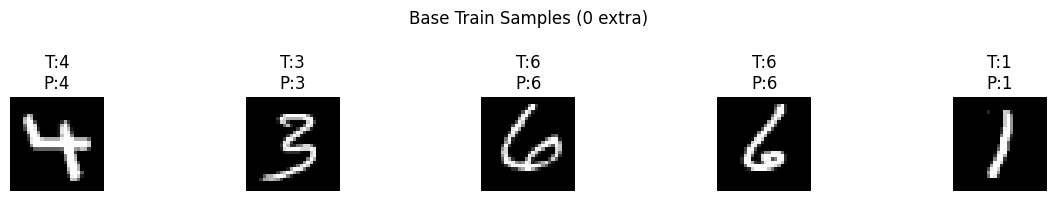

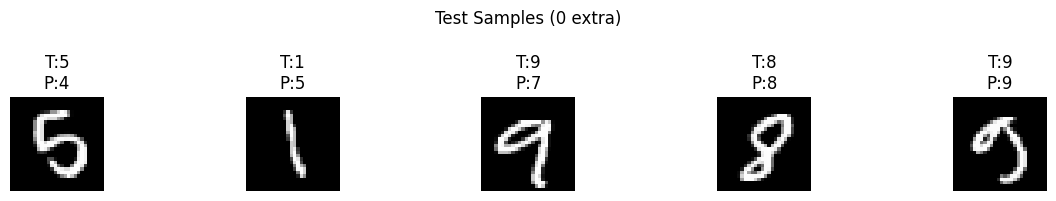

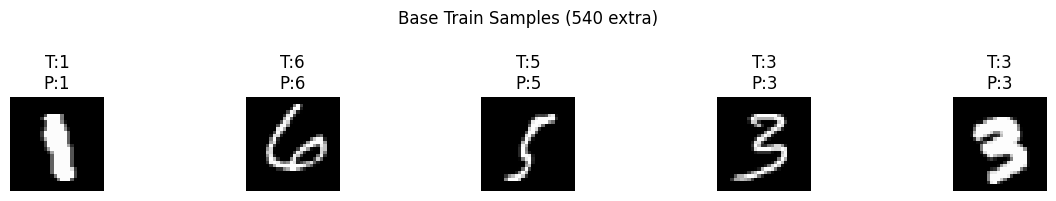

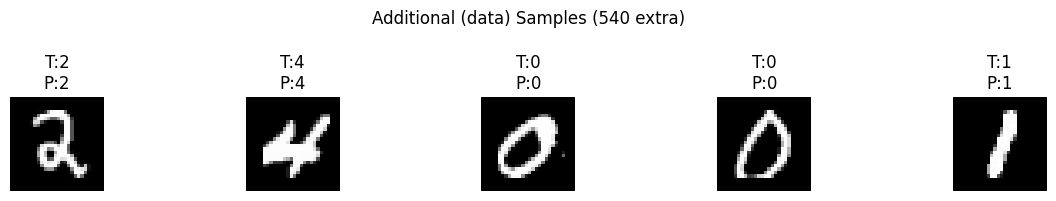

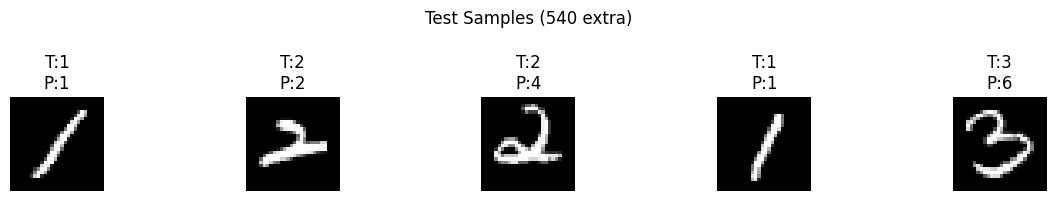

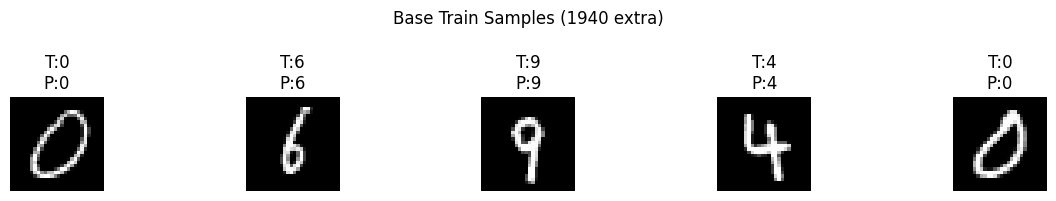

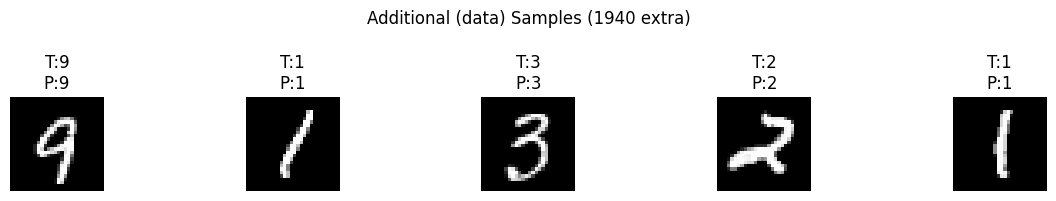

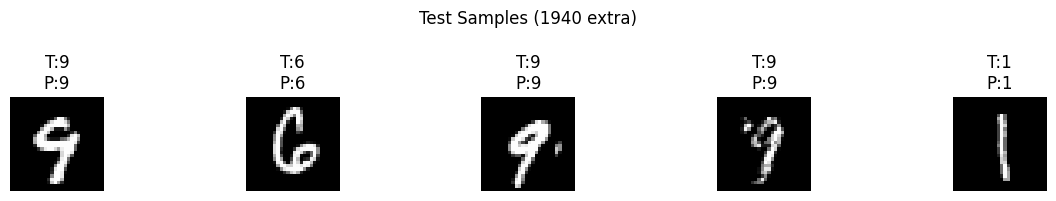

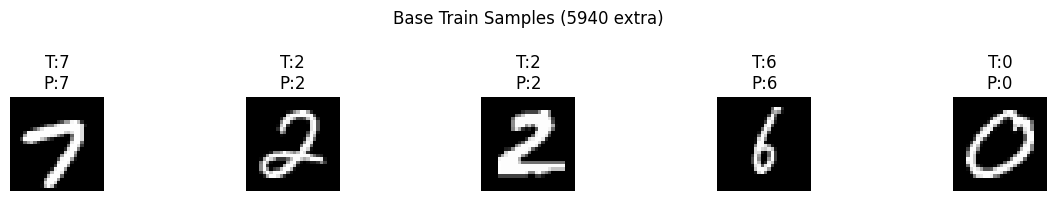

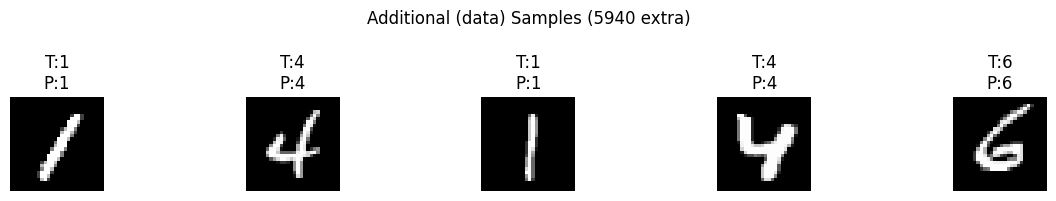

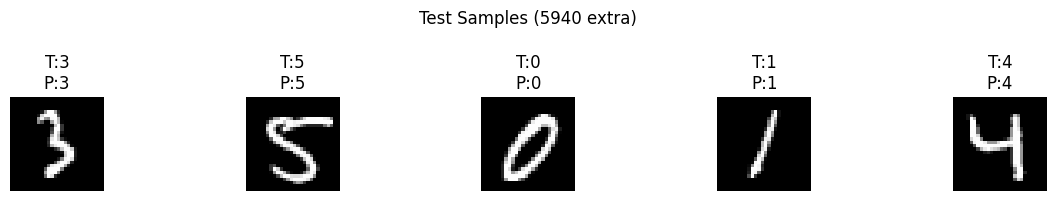

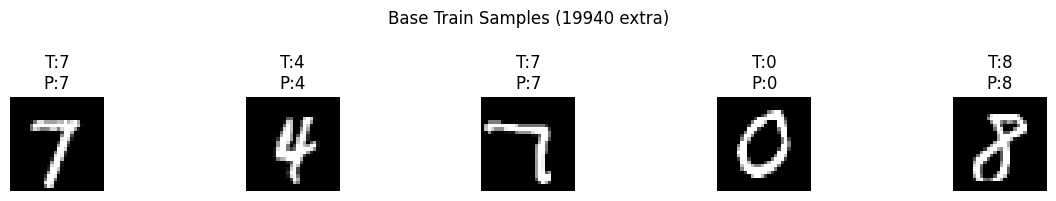

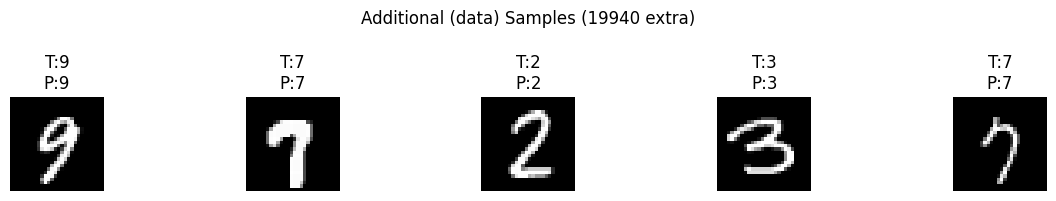

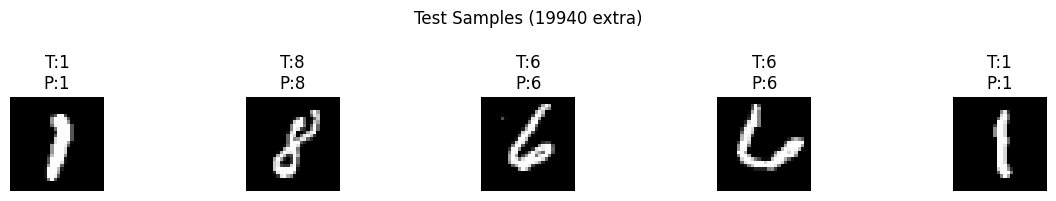

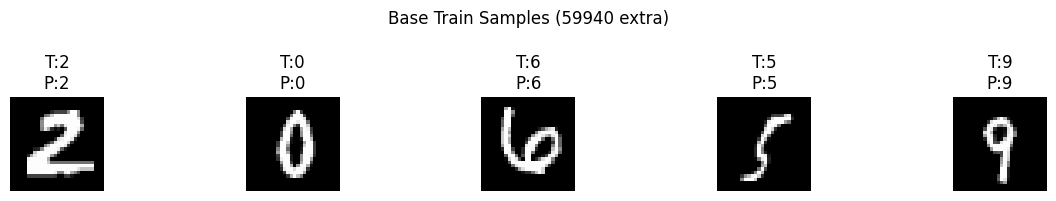

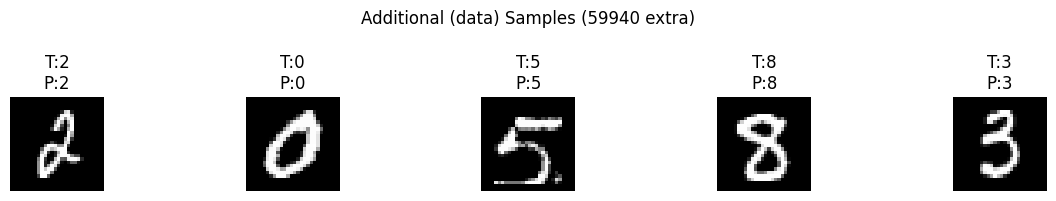

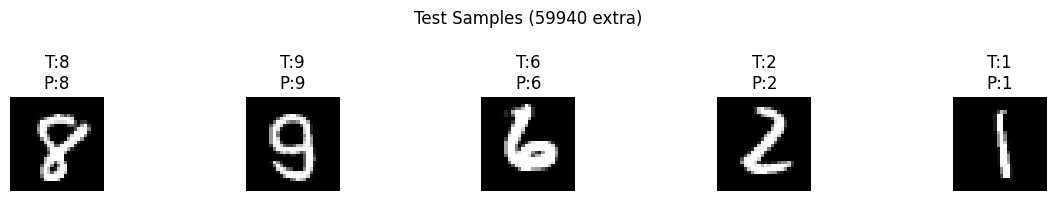

In [6]:
model_module.verify_model_results(
    all_models=all_models,
    x_base_train=x_base_train,
    y_base_train=y_base_train,
    x_additional=x_additional,
    y_additional=y_additional,
    x_test=x_test,
    y_test=y_test,
    dataset_quantities=dataset_quantities,
    dataset_type=dataset_type,
)

## Model Saving

In [7]:
# ====================================
# Save Datasets and Models
# ====================================
output_folder = "models_and_data"
# Save dataset (Possible to skip)
if save_generated_dataset:
    save_dataset(
        folder=output_folder,
        filename="dataset.pt",
        x_base_train=x_base_train,
        y_base_train=y_base_train,
        x_additional=x_additional,
        y_additional=y_additional,
        x_test=x_test,
        y_test=y_test,
        dataset_quantities=dataset_quantities,
        dataset_type=dataset_type,
    )
    print(f"Saved dataset to {output_folder}/dataset.pt")

# Save trained models
if save_generated_models:
    for model_data in all_models:
        filename = f"model_additional_{model_data['additional_data']}.pt"
        save_model(
            folder=output_folder,
            filename=filename,
            model=model_data["model"],
            train_loss=model_data["train_loss"],
            train_accs=model_data["train_accs"],
            test_loss=model_data["test_loss"],
            test_accs=model_data["test_accs"],
            additional_data=model_data["additional_data"],
            dataset_type=model_data["dataset_type"],
        )
        print(f"Saved model: {output_folder}/{filename}")

✅ Dataset saved to models_and_data\dataset.pt
Saved dataset to models_and_data/dataset.pt
✅ Model saved to models_and_data\model_additional_0.pt
Saved model: models_and_data/model_additional_0.pt
✅ Model saved to models_and_data\model_additional_540.pt
Saved model: models_and_data/model_additional_540.pt
✅ Model saved to models_and_data\model_additional_1940.pt
Saved model: models_and_data/model_additional_1940.pt
✅ Model saved to models_and_data\model_additional_5940.pt
Saved model: models_and_data/model_additional_5940.pt
✅ Model saved to models_and_data\model_additional_19940.pt
Saved model: models_and_data/model_additional_19940.pt
✅ Model saved to models_and_data\model_additional_59940.pt
Saved model: models_and_data/model_additional_59940.pt
